In [127]:
import pandas as pd
from pathlib import Path
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import solve, inv
from typing import Self
import statsmodels.api as sm
from dataclasses import dataclass
import scipy.stats

In [128]:
RC = {
    "figure.figsize": (10, 5),
}

DPI_EXPORT = 600
sns.set_theme(style="whitegrid", rc=RC)

In [129]:
ROOT_PATH = Path().resolve().parent
print(f"{ROOT_PATH=}")
JEPPE_PATH = ROOT_PATH / 'Jeppe'
DATA_PATH = ROOT_PATH / 'DST_BIL54.csv'
assert DATA_PATH.exists()

REPORT_DIR = ROOT_PATH / 'report'
OUTPUT_DIR = REPORT_DIR / 'output'
OUTPUT_DIR.mkdir(exist_ok=True)

ROOT_PATH=WindowsPath('C:/Users/jeppe/Documents/MEGA/Base/DTU/02417 Time Series Analysis/Assignment1')


In [130]:
# Utility numpy functions
def col(x: np.ndarray) -> np.ndarray:
    # Returns a column vector from a 1d array
    assert x.ndim == 1
    return x[:, None]

def is_col(x: np.ndarray) -> bool:
    return x.ndim == 2 and x.shape[1] == 1

def row(x: np.ndarray) -> np.ndarray:
    # Returns a row vector from a 1d array
    assert x.ndim == 1
    return x[None, :]

def is_row(x: np.ndarray) -> bool:
    return x.ndim == 2 and x.shape[0] == 1


# 1

In [131]:
# Read and format data
df = pd.read_csv(DATA_PATH)
df['time'] = pd.to_datetime(df['time'])  # Coerce to dt
df = df[["time", "total"]]
df = df.rename(columns={"total": "y"})

# Construct x columns as requested
df["x"] = df["time"].dt.year + (df["time"].dt.month - 1 ) / 12

TRAINING_CUTOFF = datetime.fromisoformat("2024-01-01")
TRAINING_CUTOFF_X = TRAINING_CUTOFF.year + (TRAINING_CUTOFF.month - 1) / 12
df_train = df[df['time'] < TRAINING_CUTOFF].copy()
df_test = df[df['time'] >= TRAINING_CUTOFF].copy()

In [132]:
df_total = pd.DataFrame(columns=[
    "x",
    "y",
    "y_pred",
    "y_pred_low",
    "y_pred_high",
    "Model",
    "Type"
])

df_train["Model"] = None
df_train["Type"] = "Train"
df_train["y_pred"] = df_train["y"]

df_test["Model"] = None
df_test["Type"] = "Test"
df_test["y_pred"] = df_test["y"]

df_total = pd.concat([df_total, df_train, df_test], ignore_index=True)

C:\Users\jeppe\AppData\Local\Temp\ipykernel_26336\926156523.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_total = pd.concat([df_total, df_train, df_test], ignore_index=True)


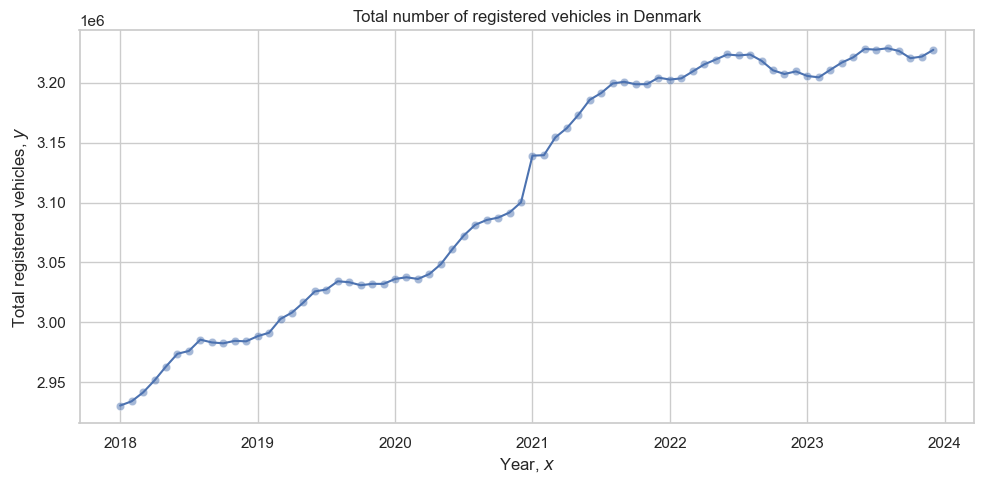

In [133]:
sns.lineplot(data=df_train, x="x", y="y")
sns.scatterplot(data=df_train, x="x", y="y", alpha=0.5)
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_observations.png", dpi=DPI_EXPORT)

## 1.2 Description of Data

We observe an increasing number of total registered vehicles in Denmark through the period from primo 2018 to ultimo 2023.
Notably, there is a sizable jump around the end of 2020, which flattens out in 2022. From 2022 onward we observe a smaller annual increase in the number of registered vehicles. This could be potentially be attributed to lower demand following the Coronavirus pandemic and the corresponding increase in remote working at many places of work. Alternatively, the reduction in the increase of registered cars could be seen as a consequence of increased fuel prices and uncertainty around the transition to Battery Electric Vehicles (BEV).



In [134]:
df_train[:3].round(3)

,time,y,x,Model,Type,y_pred
0,2018-01-01,2930483,2018.000,None,Train,2930483
1,2018-02-01,2934044,2018.083,None,Train,2934044
2,2018-03-01,2941422,2018.167,None,Train,2941422


# 2 - Linear Trend Model

We are given the following form of the General Linear Model (GLM):

$$
Y_t = θ_1 + θ_2 ⋅ x_t + ϵ_t
$$

## 2.1 - Matrix Form
We rewrite this in matrix-vector notation:

$$
\mathbf{\underbar{Y}} = \mathbf{\underbar{\underbar{X}}} \mathbf{\underbar{θ}} + \mathbf{\underbar{ϵ}}
$$

With $\mathbf{\underbar{\underbar{X}}}$ being the _design matrix_. In our case, for $N$ observations, this would be:

$$
\mathbf{\underbar{\underbar{X}}} ≡
\begin{bmatrix}
    1 & x_1 \\
    1 & x_2 \\
    ⋮ & ⋮ \\
    1 & x_n \\
\end{bmatrix}
$$

Using the first 3 time points in our training data set, we obtain:
$$
\begin{align}
\mathbf{\underbar{Y}}
&= \mathbf{\underbar{\underbar{X}}} \mathbf{\underbar{θ}} + \mathbf{\underbar{ϵ}}\\

\begin{bmatrix}
    y_1\\
    y_2\\
    y_3\\
\end{bmatrix}

&= \begin{bmatrix}
        1 & x_1 \\
        1 & x_2 \\
        1 & x_3 \\
    \end{bmatrix}

    \begin{bmatrix}
        θ_1\\
        θ_2\\
        θ_3\\
    \end{bmatrix}

    + 

    \begin{bmatrix}
        ϵ_1\\
        ϵ_2\\
        ϵ_3\\
    \end{bmatrix}\\

\begin{bmatrix}
    2930483\\
    2934044\\
    2941422\\
\end{bmatrix}

&= \begin{bmatrix}
        1 & 2018.000 \\
        1 & 2018.083 \\
        1 & 2018.167 \\
    \end{bmatrix}

    \begin{bmatrix}
        θ_1\\
        θ_2\\
        θ_3\\
    \end{bmatrix}

    + 

    \begin{bmatrix}
        ϵ_1\\
        ϵ_2\\
        ϵ_3\\
    \end{bmatrix}\\
\end{align}
$$



## 2.2 - Parameter Estimates

We wish to solve for $\mathbf{\underbar{θ}}$:

$$
\mathbf{\underbar{θ}} = (X^T X)^{-1} X^T Y
$$

And obtain estimates of the standard error

In [ ]:
@dataclass
class Dataset:
    design_matrix: np.ndarray  # [N, P] matrix
    response: np.ndarray  # [N, 1] column vector

    @property
    def x(self) -> np.ndarray:
        return self.design_matrix[:, 1]

    @property
    def y(self) -> np.ndarray:
        return self.response

    @property
    def n_params(self) -> int:
        X = self.design_matrix
        return X.shape[1]

    @property
    def n_observations(self) -> int:
        X = self.design_matrix
        return X.shape[0]

    @classmethod
    def linear_from_dataframe(cls: Self, df: pd.DataFrame) -> Self:
        X = np.zeros((len(df["x"]), 2))
        X[:, 0] = 1
        X[:, 1] = df["x"]

        Y = col(np.asarray(df["y"]))

        assert Y.shape[0] == X.shape[0]

        return cls(design_matrix=X, response=Y)


@dataclass
class PredictionResult:
    prediction_dataset: Dataset
    model_dataset: Dataset
    model_residuals: np.ndarray  # [N, 1] column vector

    parameters_prediction: np.ndarray  # [P, 1] column vector
    response_prediction: np.ndarray  # [N, 1] column vector

    def get_rss(self) -> float:
        epsilon = self.model_residuals
        return epsilon.T @ epsilon

    def get_standard_deviation(self) -> float:
        n = self.model_dataset.n_observations
        p = self.model_dataset.n_params
        return np.sqrt(self.get_rss() / (n - p))

    def get_parameter_covariance(self) -> np.ndarray:
        X = self.model_dataset.design_matrix
        sd = self.get_standard_deviation()
        return sd**2 * inv(X.T @ X)

    def get_parameter_variances(self) -> np.ndarray:
        return col(np.diag(self.get_parameter_covariance()))

    def get_parameter_standard_errors(self) -> np.ndarray:
        return np.sqrt(self.get_parameter_variances())

    def get_prediction_covariance(self) -> np.ndarray:
        X_model = self.model_dataset.design_matrix
        X_prediction = self.prediction_dataset.design_matrix
        sd = self.get_standard_deviation()
        return sd**2 * (1 + X_prediction @ inv(X_model.T @ X_model) @ X_prediction.T)

    def get_prediction_variances(self) -> np.ndarray:
        return col(np.diag(self.get_prediction_covariance()))

    def get_prediction_standard_errors(self) -> np.ndarray:
        return np.sqrt(self.get_prediction_variances())

    def get_prediction_intervals(
        self, sigma: float | None = None, alpha: float | None = None
    ) -> np.ndarray:
        assert sigma is not None or alpha is not None

        if alpha is not None:
            n_sigma_upper = scipy.stats.norm.ppf(1 - alpha / 2)
            n_sigma_lower = scipy.stats.norm.ppf(alpha / 2)

        else:
            n_sigma_upper = sigma
            n_sigma_lower = -sigma

        sd = self.get_prediction_standard_errors()
        sd_upper = n_sigma_upper * sd
        sd_lower = n_sigma_lower * sd

        return (
            self.response_prediction + sd_lower,
            self.response_prediction + sd_upper,
        )

    def forecast(self, forecast_ds: Dataset) -> Self:
        X = forecast_ds.design_matrix
        assert X.shape[1] == self.model_dataset.n_params

        y_pred = X @ self.parameters_prediction
        return PredictionResult(
            prediction_dataset=forecast_ds,
            model_dataset=self.model_dataset,
            model_residuals=self.model_residuals,
            parameters_prediction=self.parameters_prediction,
            response_prediction=y_pred,
        )


# sigma2 = ols_train.get_standard_deviation() ** 2
# # TODO: Derive this in report
# covariance_pred = sigma2 * (1 + X_prediction @ np.linalg.inv(X.T @ X) @ X_prediction.T)
# variance_pred = np.diag(covariance_pred)
# standard_errors_pred = np.sqrt(variance_pred)
# p95_pred = 1.96 * standard_errors_pred
# df_prediction["y_low"] = df_prediction["y"] - p95_pred
# df_prediction["y_high"] = df_prediction["y"] + p95_pred

In [136]:
# Set up data sets
ds_train = Dataset.linear_from_dataframe(df_train)
ds_test = Dataset.linear_from_dataframe(df_test)
ds_total = Dataset.linear_from_dataframe(df)


In [137]:
def ols(ds: Dataset) -> PredictionResult:
    X = ds.design_matrix
    y = ds.response
    assert is_col(y)
    theta = inv(X.T @ X) @ X.T @ y  # θ

    y_pred = X @ theta

    return PredictionResult(
        prediction_dataset=ds,
        model_dataset=ds,
        model_residuals=y - y_pred,
        parameters_prediction=theta,
        response_prediction=y_pred,
    )


In [138]:
ols_train = ols(ds_train)
print(ols_train.parameters_prediction)
print(ols_train.get_parameter_standard_errors())



[[-1.10355428e+08]
 [ 5.61445562e+04]]
[[3.59358112e+06]
 [1.77815630e+03]]


In [139]:
# Verify against statsmodels implementation
Y_OLS = df_train["y"]
X_OLS = sm.add_constant(df_train["x"])
model = sm.OLS(Y_OLS, X_OLS)
results = model.fit()
results.params

const   -1.103554e+08
x        5.614456e+04
dtype: float64

In [140]:
# Prediction
df_ols = pd.DataFrame()
df_ols["x"] = ds_train.x
df_ols["y"] = ds_train.y
df_ols["y_pred"] = ols_train.response_prediction
(df_ols["y_pred_high"], df_ols["y_pred_low"], ) = ols_train.get_prediction_intervals(alpha=0.05)
df_ols["Model"] = "OLS"
df_ols["Type"] = "Prediction"

df_total = pd.concat([df_total, df_ols], ignore_index=True)

C:\Users\jeppe\AppData\Local\Temp\ipykernel_26336\1229525485.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_total = pd.concat([df_total, df_ols], ignore_index=True)


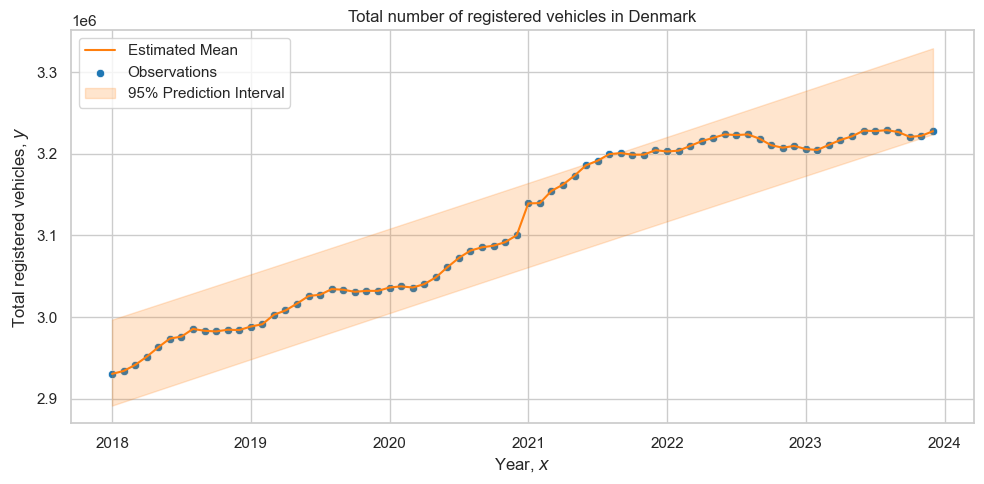

In [141]:
sns.lineplot(data=df_ols, x="x", y="y", label="Estimated Mean", c="tab:orange")
sns.scatterplot(data=df_train, x="x", y="y", label="Observations", c="tab:blue")
plt.fill_between(df_ols["x"], df_ols["y_pred_low"], df_ols["y_pred_high"], color="tab:orange", alpha=0.2, label="95% Prediction Interval")
plt.legend()
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_observations_predicted.png", dpi=DPI_EXPORT)

## 2.3 Forecast

In [142]:
ols_forecast = ols_train.forecast(ds_test)
df_ols_forecast = pd.DataFrame()
df_ols_forecast["x"] = ds_test.x
df_ols_forecast["y"] = ds_test.y
df_ols_forecast["y_pred"] = ols_forecast.response_prediction
(df_ols_forecast["y_pred_high"], df_ols_forecast["y_pred_low"], ) = ols_forecast.get_prediction_intervals(alpha=0.05)
df_ols_forecast["Model"] = "OLS"
df_ols_forecast["Type"] = "Forecast"

df_total = pd.concat([df_total, df_ols_forecast], ignore_index=True)


In [143]:
df_ols_forecast_output = df_ols_forecast[["x", "y", "y_pred_low", "y_pred_high"]].copy()
df_ols_forecast_output["x"] = df_ols_forecast_output["x"].map("{:.3f}".format)
df_ols_forecast_output[["y", "y_pred_low", "y_pred_high"]] = df_ols_forecast_output[
    ["y", "y_pred_low", "y_pred_high"]
].astype(int)
df_ols_forecast_output = df_ols_forecast_output.rename(
    columns={
        "x": "Time",
        "y": "Total Vehicles Registered",
        "y_pred_low": "95% Confidence Interval, lower bound",
        "y_pred_high": "95% Confidence Interval, upper bound",
    }
)
df_ols_forecast_output.to_csv(OUTPUT_DIR / "ols_forecast.csv", index=False)

## 2.4 Plot of forecast

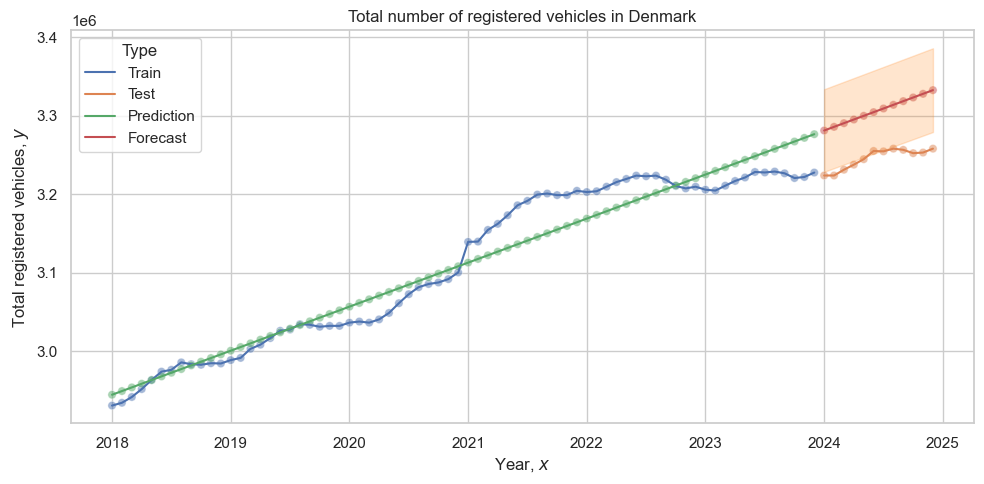

In [144]:
sns.lineplot(data=df_total, x="x", y="y_pred", hue="Type")
sns.scatterplot(data=df_total, x="x", y="y_pred", hue="Type", alpha=0.5, legend=False)
plt.fill_between(df_ols_forecast["x"], df_ols_forecast["y_pred_low"], df_ols_forecast["y_pred_high"], color="tab:orange", alpha=0.2, label="95% Prediction Interval")
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_observations_forecast.png", dpi=DPI_EXPORT)

## 2.5

## 2.6 Residuals

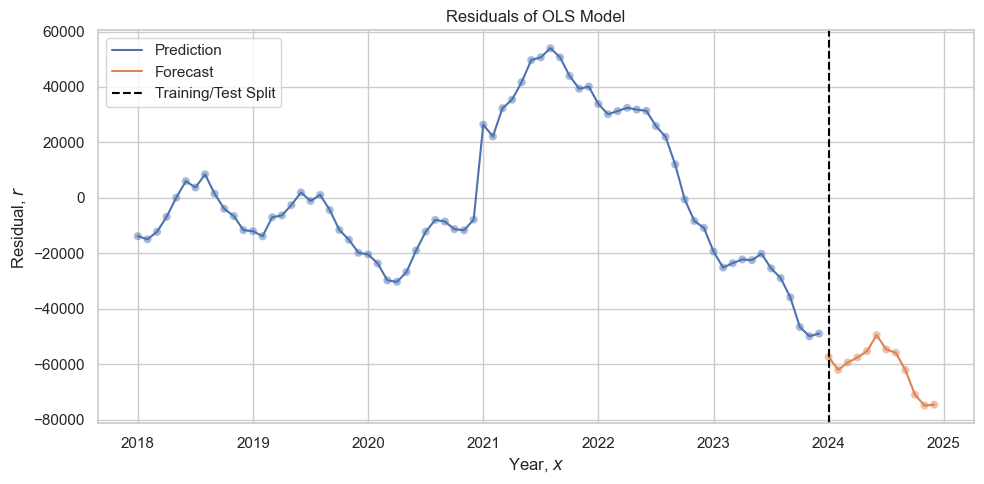

In [145]:
df_ols_residuals = df_total.query("Model == 'OLS'").copy()
df_ols_residuals["residual"] = df_ols_residuals["y"] - df_ols_residuals["y_pred"]
sns.lineplot(data=df_ols_residuals, x="x", y="residual", hue="Type")
sns.scatterplot(data=df_ols_residuals, x="x", y="residual", hue="Type", alpha=0.5, legend=False)
plt.title("Residuals of OLS Model")
plt.xlabel("Year, $x$")
plt.ylabel("Residual, $r$")
plt.axvline(TRAINING_CUTOFF_X, color="black", linestyle="--", label="Training/Test Split")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_2_6_forecast_residuals.png", dpi=DPI_EXPORT)

# 3 WLS

## 3.1

## 3.2

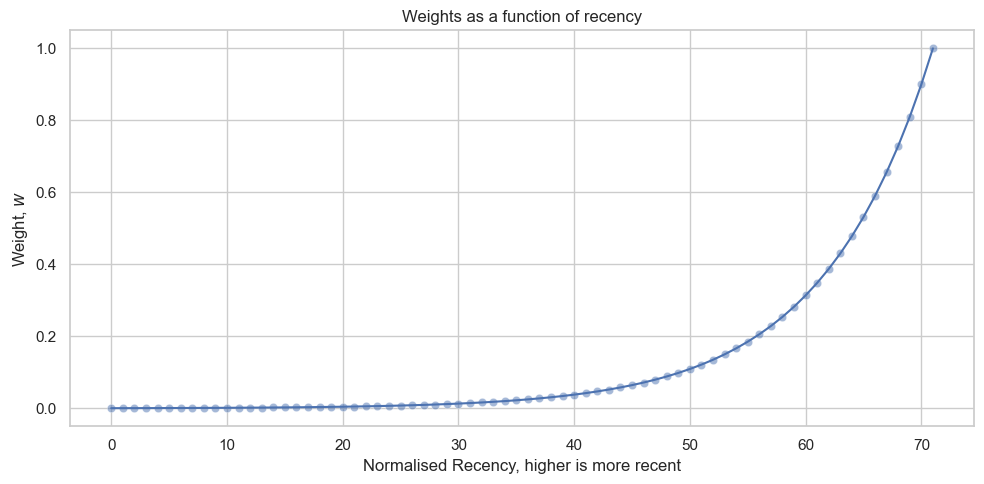

In [146]:
lambda_ = 0.9

N_times = len(df_train)
times = np.arange(N_times)
weights = np.asarray([lambda_ ** (N_times - i - 1) for i in times])

sns.lineplot(x=times, y=weights)
sns.scatterplot(x=times, y=weights, alpha=0.5)

plt.title("Weights as a function of recency")
plt.xlabel("Normalised Recency, higher is more recent")
plt.ylabel("Weight, $w$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_3_2_weights.png", dpi=DPI_EXPORT)

## 3.3

In [147]:
N_times = 72
times = np.arange(N_times)
weights = np.asarray([lambda_ ** (N_times - i - 1) for i in times])
np.sum(weights)

np.float64(9.994924712139436)

## 3.4

In [ ]:
@dataclass
class PredictionResultWLS(PredictionResult):
    prediction_dataset: Dataset
    model_dataset: Dataset
    model_weights: np.ndarray  # [N, 1] column vector
    model_residuals: np.ndarray  # [N, 1] column vector

    parameters_prediction: np.ndarray  # [P, 1] column vector
    response_prediction: np.ndarray  # [N, 1] column vector

    def get_total_memory(self) -> float:
        return np.sum(self.model_weights)

    def get_standard_deviation(self) -> float:
        T = self.get_total_memory()
        p = self.model_dataset.n_params
        return np.sqrt(self.get_rss() / (T - p))

    def get_rss(self) -> float:
        epsilon = self.model_residuals
        W = self.model_weights
        return epsilon.T @ W @ epsilon

    def get_parameter_covariance(self) -> np.ndarray:
        X = self.model_dataset.design_matrix
        W = self.model_weights
        sd = self.get_standard_deviation()
        return sd**2 * inv(X.T @ W @ X)

    def get_parameter_variances(self) -> np.ndarray:
        return col(np.diag(self.get_parameter_covariance()))

    def get_parameter_standard_errors(self) -> np.ndarray:
        return np.sqrt(self.get_parameter_variances())

    def get_prediction_covariance(self) -> np.ndarray:
        X_model = self.model_dataset.design_matrix
        X_prediction = self.prediction_dataset.design_matrix
        W = self.model_weights
        sd = self.get_standard_deviation()
        return sd**2 * (1 + X_prediction @ inv(X_model.T @ W @ X_model) @ X_prediction.T)

    def forecast(self, forecast_ds: Dataset) -> Self:
        X = forecast_ds.design_matrix
        assert X.shape[1] == self.model_dataset.n_params

        y_pred = X @ self.parameters_prediction
        return PredictionResultWLS(
            prediction_dataset=forecast_ds,
            model_dataset=self.model_dataset,
            model_weights=self.model_weights,
            model_residuals=self.model_residuals,
            parameters_prediction=self.parameters_prediction,
            response_prediction=y_pred,
        )

def wls(ds: Dataset, lambda_: float) -> PredictionResult:
    X = ds.design_matrix
    y = ds.response
    assert is_col(y)

    N = ds.n_observations
    W = np.diag([lambda_ ** (N - i - 1) for i in range(N)])

    theta = inv(X.T @ W @ X) @ X.T @ W @ y

    y_pred = X @ theta

    return PredictionResultWLS(
        prediction_dataset=ds,
        model_dataset=ds,
        model_weights=W,
        model_residuals=y - y_pred,
        parameters_prediction=theta,
        response_prediction=y_pred,
    )

In [171]:
wls_train = wls(ds_train, lambda_=0.9)
print(wls_train.parameters_prediction)
print(wls_train.get_parameter_standard_errors())

[[-5.24828618e+07]
 [ 2.75299016e+04]]
[[1.51824147e+07]
 [7.50427088e+03]]


## 3.5

In [172]:
# Prediction
df_wls = pd.DataFrame()
df_wls["x"] = ds_train.x
df_wls["y"] = ds_train.y
df_wls["y_pred"] = wls_train.response_prediction
(df_wls["y_pred_high"], df_wls["y_pred_low"], ) = wls_train.get_prediction_intervals(alpha=0.05)
df_wls["Model"] = "WLS"
df_wls["Type"] = "Prediction"

df_total = pd.concat([df_total, df_wls], ignore_index=True)

AAA
AAA


In [173]:
# Forecast
wls_forecast = wls_train.forecast(ds_test)
df_wls_forecast = pd.DataFrame()
df_wls_forecast["x"] = ds_test.x
df_wls_forecast["y"] = ds_test.y
df_wls_forecast["y_pred"] = wls_forecast.response_prediction
(df_wls_forecast["y_pred_high"], df_wls_forecast["y_pred_low"], ) = wls_forecast.get_prediction_intervals(alpha=0.05)
df_wls_forecast["Model"] = "WLS"
df_wls_forecast["Type"] = "Forecast"

df_total = pd.concat([df_total, df_wls_forecast], ignore_index=True)


AAA
AAA


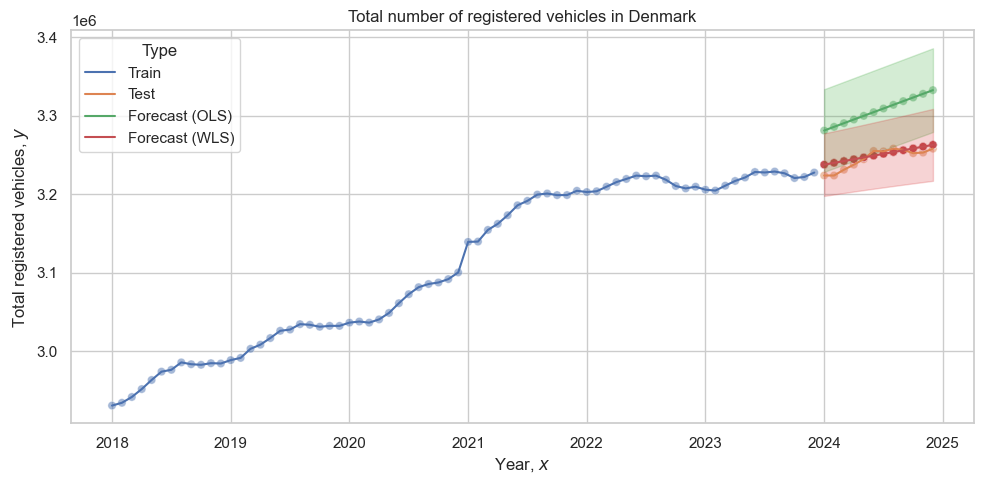

In [174]:
# df_prediction
df_forecasts = df_total.query("Type == 'Forecast'").copy()
df_forecasts["Type"] = df_forecasts["Type"] + " (" + df_forecasts["Model"] + ")"
df_plot = pd.concat([df_train, df_test, df_forecasts], ignore_index=True)

sns.lineplot(data=df_plot, x="x", y="y_pred", hue="Type")
sns.scatterplot(data=df_plot, x="x", y="y_pred", hue="Type", alpha=0.5, legend=False)
plt.fill_between(df_ols_forecast["x"], df_ols_forecast["y_pred_low"], df_ols_forecast["y_pred_high"], color="tab:green", alpha=0.2, label="95% Prediction Interval")
plt.fill_between(df_wls_forecast["x"], df_wls_forecast["y_pred_low"], df_wls_forecast["y_pred_high"], color="tab:red", alpha=0.2, label="95% Prediction Interval")

plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_3_5_forecast_wls_ols.png", dpi=DPI_EXPORT)

## 3.6

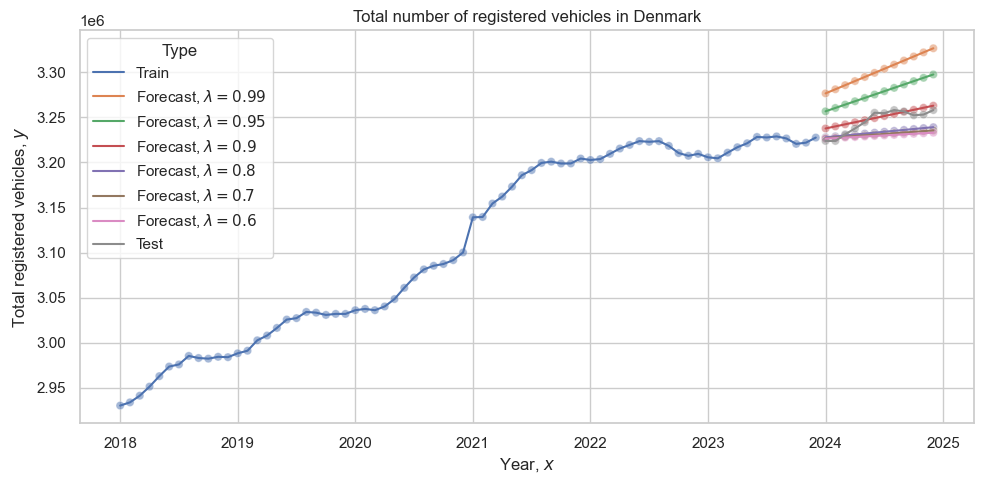

In [84]:
def predict(lambda_):
    wls_obj = wls(ds_train, lambda_)
    wls_forecast = wls_obj.forecast(ds_test)

    df_wls_forecast = pd.DataFrame()
    df_wls_forecast["x"] = ds_test.x
    df_wls_forecast["y"] = ds_test.y
    df_wls_forecast["y_pred"] = wls_forecast.response_prediction
    (df_wls_forecast["y_pred_high"], df_wls_forecast["y_pred_low"], ) = wls_forecast.get_prediction_intervals(alpha=0.05)
    df_wls_forecast["Model"] = "WLS"
    df_wls_forecast["Type"] = "Forecast"
    df_wls_forecast["lambda"] = lambda_

    return df_wls_forecast

dfs = []
for lambda_ in [0.99, 0.95, 0.90, 0.8, 0.7, 0.6]:
    dfs.append(predict(lambda_))

df_forecasts = pd.concat(dfs)
df_forecasts["Type"] = "Forecast, $λ=" + df_forecasts["lambda"].astype("str") + "$"
df_total_forecasts= pd.concat([df_train, df_forecasts, df_test])

sns.lineplot(data=df_total_forecasts, x="x", y="y_pred", hue="Type")
sns.scatterplot(data=df_total_forecasts, x="x", y="y_pred", hue="Type", alpha=0.5, legend=False)
plt.title("Total number of registered vehicles in Denmark")
plt.xlabel("Year, $x$")
plt.ylabel("Total registered vehicles, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_3_6_forgetting_factors.png", dpi=DPI_EXPORT)



In [85]:
# Verify against WLS from statsmodels
lambda_verify = 0.7
Y_WLS = df_train["y"]
X_WLS = sm.add_constant(df_train["x"])
weights = lambda_verify ** np.arange(len(df_train))[::-1]
model_WLS = sm.WLS(Y_WLS, X_WLS, weights=weights)
results_WLS = model_WLS.fit()
results_WLS.params

const   -1.573998e+07
x        9.370982e+03
dtype: float64

In [86]:
wls(ds_train, lambda_=lambda_verify).parameters_prediction

array([[-1.57399787e+07],
       [ 9.37098201e+03]])

# 4


## 4.2

array([[-51837.16474871],
       [  1561.56703233]])

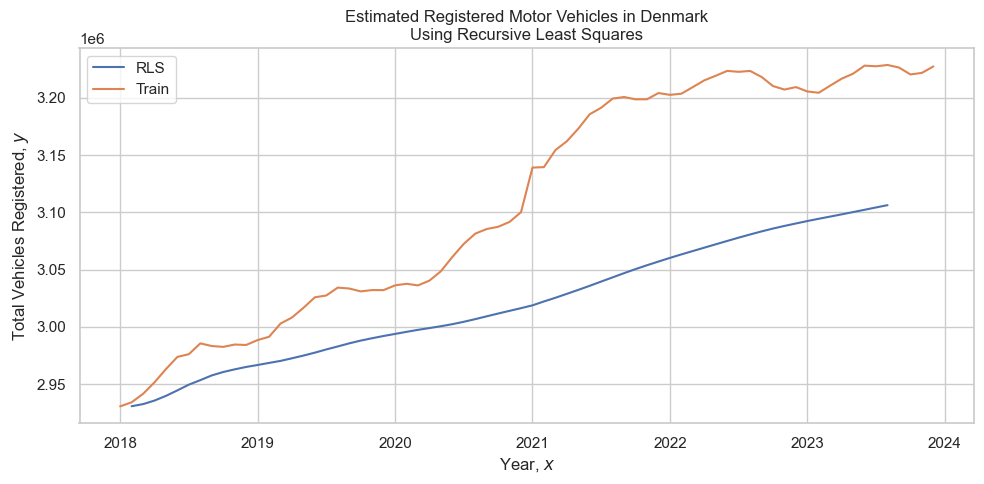

In [87]:
def iterate(R, theta, x_t, y_t):
    """
    Updates matrix R and parameter vector theta using observations
    in vector x_t corresponding to outcome scalar y_t.

    Arguments:
        R: Matrix of shape (N, N) where N is the number of features.

        theta: Vector of shape (N, 1) where N is the number of features.
            Parameters of GLM model
        x_t: Vector of shape (N, 1) where N is the number of features.
            Exogenous variables of observations.
        y_t: Scalar outcome.
            Endogenous variable of observations.


    Vectors are columns vectors.
    """
    N = x_t.shape[0]
    assert R.shape == (N, N)
    assert theta.shape == (N, 1)
    assert x_t.shape == (N, 1)
    assert y_t.shape == tuple() or y_t.shape == (1,)

    R_t = R + x_t @ x_t.T
    # theta_t = theta + (inv(R_t) @ x_t) * (y_t - x_t.T @ theta)
    theta_t = theta + inv(R_t) @ x_t @ (y_t - x_t.T @ theta)

    return R_t, theta_t


R_0 = 0.1 * np.eye(2)
# R_0 = inv(X.T @ X)  # Good start guess
theta_0 = np.zeros((2, 1))
# theta_0 = thetas_OLS[:, None]

X = ds_train.design_matrix
Y = ds_train.response
x_t = X[0, :][:, None]
y_t = Y[0]

R = R_0.copy()
theta = theta_0.copy()
t_stop = X.shape[0]
t_stop = X.shape[0] - 3 - 1  # Assuming up to t-3 is not inclusive
thetas_rls_1 = np.empty((t_stop+1, 2))
thetas_rls_1[0, :] = theta.T
for i in range(0, t_stop):
    x_t = X[i, :][:, None]
    y_t = Y[i]


    R, theta = iterate(R, theta, x_t, y_t)
    thetas_rls_1[i+1, :] = theta.T

R
theta

y = []
x = []
for i in range(thetas_rls_1.shape[0] - 1):
    y_pred = X @ thetas_rls_1[i, :].T
    y.append(y_pred[i])
    x.append(X[i, 1])
K = 1

plt.figure()
plt.plot(x[K:], y[K:], label="RLS")
sns.lineplot(df_train, x="x", y="y", label="Train")
plt.title("Estimated Registered Motor Vehicles in Denmark\nUsing Recursive Least Squares")
plt.xlabel("Year, $x$")
plt.ylabel("Total Vehicles Registered, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_2_rls.png", dpi=DPI_EXPORT)

theta

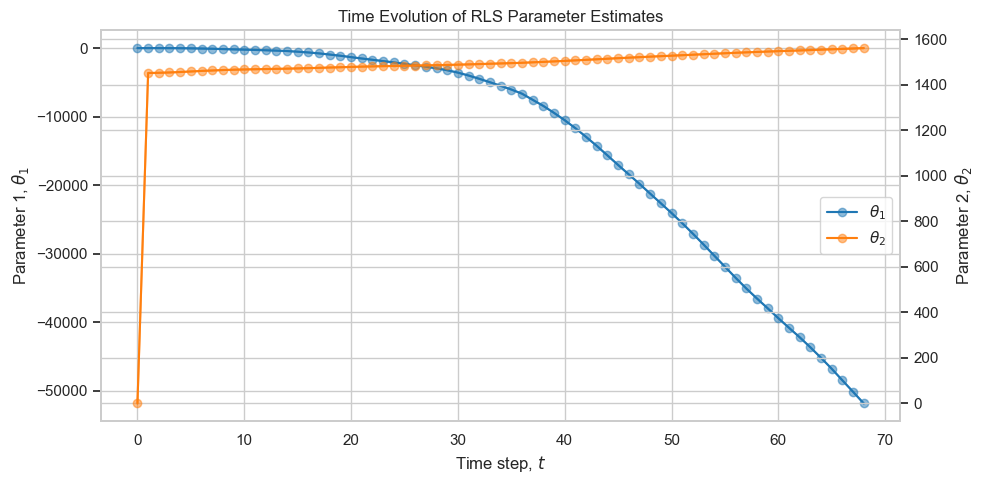

In [88]:
plt.figure()
t = np.arange(thetas_rls_1.shape[0])
thetas_1_l, = plt.plot(t, thetas_rls_1[:, 0], c="tab:blue")
thetas_1_s, = plt.plot(t, thetas_rls_1[:, 0], c="tab:blue", alpha=0.5, marker="o")
plt.xlabel("Time step, $t$")
plt.ylabel("Parameter 1, $θ_1$")

ax2 = plt.twinx()
plt.ylabel("Parameter 2, $θ_2$")
# thetas_2 = sns.lineplot(thetas_rls_1[:, 1], label="$θ_2$", c="tab:orange")
thetas_2_l, = plt.plot(t, thetas_rls_1[:, 1], c="tab:orange")
thetas_2_s, = plt.plot(t, thetas_rls_1[:, 1], c="tab:orange", alpha=0.5, marker="o")
plt.legend([(thetas_1_l, thetas_1_s), (thetas_2_l, thetas_2_s)], ["$θ_1$", "$θ_2$"], loc="center right")
plt.title("Time Evolution of RLS Parameter Estimates")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_2_rls_parameters.png", dpi=DPI_EXPORT)

## 4.3

In [89]:
### RLS bad start full data
R_0 = 0.1 * np.eye(2)
# R_0 = inv(X.T @ X)  # Good start guess
theta_0 = np.zeros((2, 1))
# theta_0 = theta_pred[:, None]

x_t = X[0, :][:, None]
y_t = Y[0]

R = R_0.copy()
theta = theta_0.copy()
t_stop = X.shape[0]
thetas_rls_2 = np.empty((t_stop+1, 2))
thetas_rls_2[0, :] = theta.T
for i in range(0, t_stop):
    x_t = X[i, :][:, None]
    y_t = Y[i]

    R, theta = iterate(R, theta, x_t, y_t)
    thetas_rls_2[i+1, :] = theta.T

R
theta

# RLS in table @table:4_3_comparison_parameters

array([[-58319.43118089],
       [  1567.95964503]])

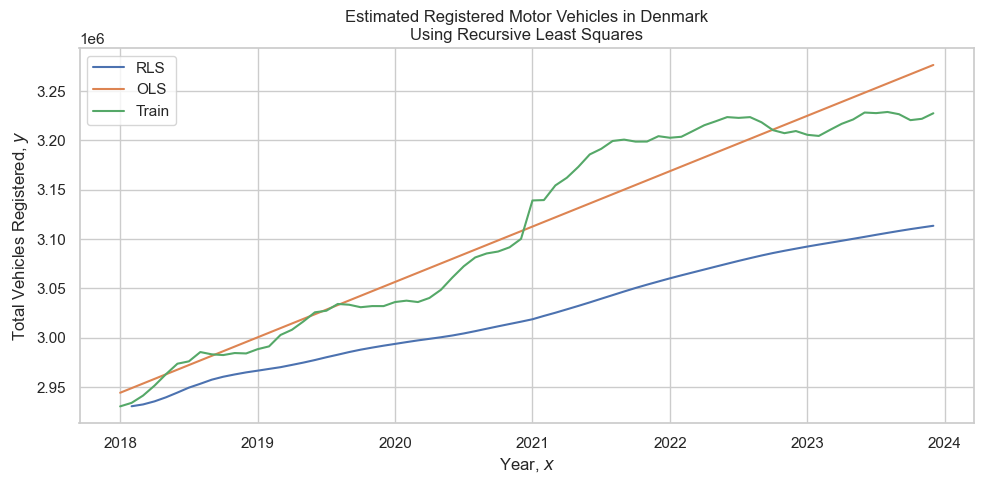

In [90]:
y = []
x = []
for i in range(thetas_rls_2.shape[0] - 1):
    y_pred = X @ thetas_rls_2[i, :].T
    y.append(y_pred[i])
    x.append(X[i, 1])
K = 1

plt.figure()
plt.plot(x[K:], y[K:], label="RLS")
sns.lineplot(df_ols, x="x", y="y_pred", label="OLS")
sns.lineplot(df_train, x="x", y="y_pred", label="Train")
plt.title("Estimated Registered Motor Vehicles in Denmark\nUsing Recursive Least Squares")
plt.xlabel("Year, $x$")
plt.ylabel("Total Vehicles Registered, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_3_ols_rls.png", dpi=DPI_EXPORT)

In [91]:
# Verify against statsmodels
Y_RLS = df_train["y"]
X_RLS = sm.add_constant(df_train["x"])
model_RLS = sm.RecursiveLS(Y_RLS, X_RLS)
results_RLS = model_RLS.fit()
results_RLS.params

c:\Users\jeppe\Documents\MEGA\Base\DTU\02417 Time Series Analysis\Assignment1\.venv\Lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1762: RuntimeWarning: invalid value encountered in scalar divide
  self.scale = np.sum(scale_obs[d:]) / nobs_k_endog


const   -1.173681e+08
x        5.961208e+04
dtype: float64

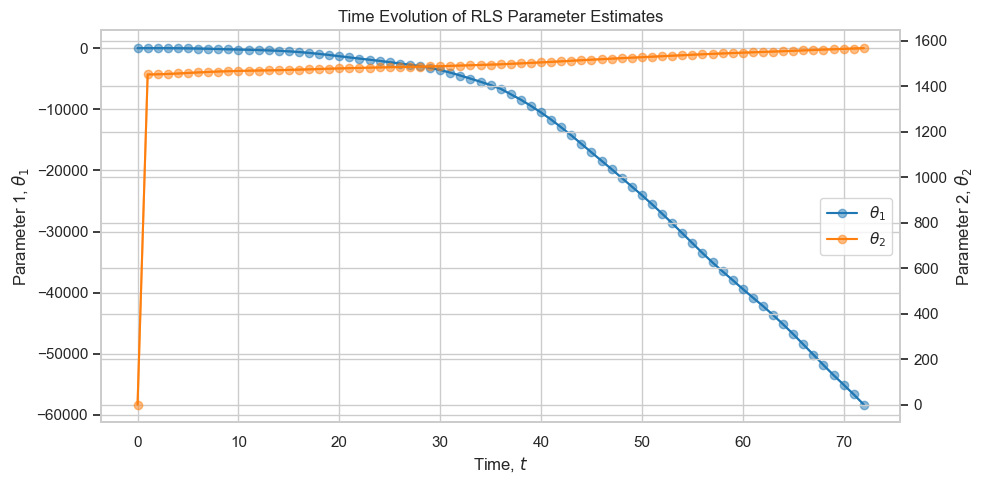

In [92]:
fig, ax1 = plt.subplots()
t = np.arange(thetas_rls_2.shape[0])
thetas_1_l, = plt.plot(t, thetas_rls_2[:, 0], c="tab:blue")
thetas_1_s, = plt.plot(t, thetas_rls_2[:, 0], c="tab:blue", alpha=0.5, marker="o")
plt.xlabel("Time, $t$")
plt.ylabel("Parameter 1, $θ_1$")

ax2 = plt.twinx()
plt.ylabel("Parameter 2, $θ_2$")
thetas_2_l, = plt.plot(t, thetas_rls_2[:, 1], c="tab:orange")
thetas_2_s, = plt.plot(t, thetas_rls_2[:, 1], c="tab:orange", alpha=0.5, marker="o")

plt.legend([(thetas_1_l, thetas_1_s), (thetas_2_l, thetas_2_s)], ["$θ_1$", "$θ_2$"], loc="center right")
plt.title("Time Evolution of RLS Parameter Estimates")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_3_rls_parameters.png", dpi=DPI_EXPORT)

In [93]:
### RLS Good initial guess
R_0 = 10e-8 * np.eye(2)
# theta_0 = np.zeros((2, 1))
theta_0 = np.asarray([[-100e6], [50e3]])
# theta_0 = theta_pred[:, None]

x_t = X[0, :][:, None]
y_t = Y[0]

R = R_0.copy()
theta = theta_0.copy()
t_stop = X.shape[0]
thetas_rls_3 = np.empty((t_stop+1, 2))
thetas_rls_3[0, :] = theta.T
for i in range(0, t_stop):
    x_t = X[i, :][:, None]
    y_t = Y[i]

    R, theta = iterate(R, theta, x_t, y_t)
    thetas_rls_3[i+1, :] = theta.T

R
theta

# RLS in table @table:4_3_comparison_parameters

array([[-1.10335881e+08],
       [ 5.61348839e+04]])

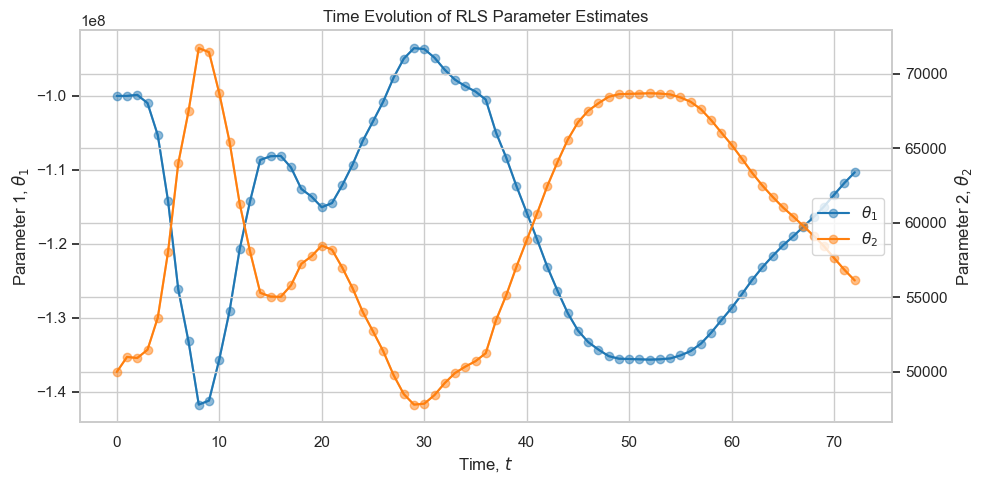

In [94]:
fig, ax1 = plt.subplots()
t = np.arange(thetas_rls_3.shape[0])
thetas_1_l, = plt.plot(t, thetas_rls_3[:, 0], c="tab:blue")
thetas_1_s, = plt.plot(t, thetas_rls_3[:, 0], c="tab:blue", alpha=0.5, marker="o")
plt.xlabel("Time, $t$")
plt.ylabel("Parameter 1, $θ_1$")

ax2 = plt.twinx()
plt.ylabel("Parameter 2, $θ_2$")
thetas_2_l, = plt.plot(t, thetas_rls_3[:, 1], c="tab:orange")
thetas_2_s, = plt.plot(t, thetas_rls_3[:, 1], c="tab:orange", alpha=0.5, marker="o")

plt.legend([(thetas_1_l, thetas_1_s), (thetas_2_l, thetas_2_s)], ["$θ_1$", "$θ_2$"], loc="center right")
plt.title("Time Evolution of RLS Parameter Estimates")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_3_good_rls_parameters.png", dpi=DPI_EXPORT)

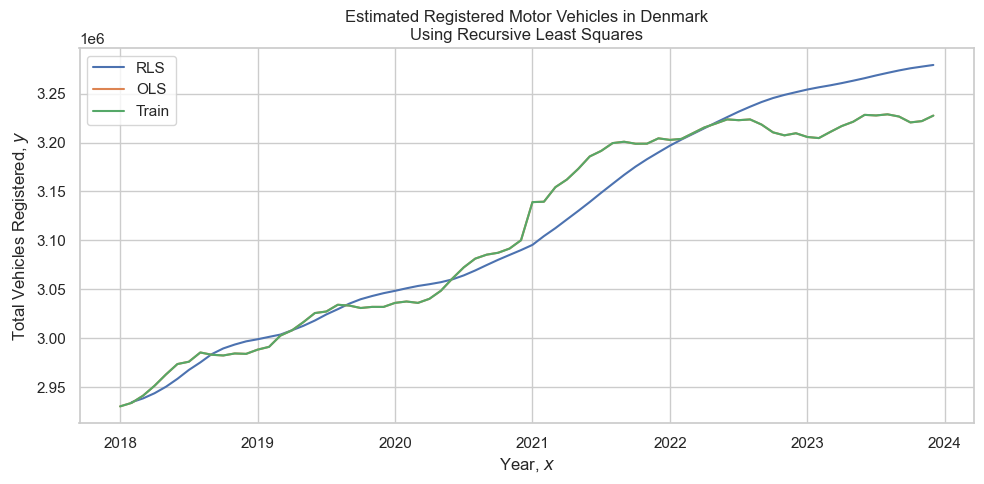

In [95]:
y = []
x = []
for i in range(thetas_rls_3.shape[0] - 1):
    y_pred = X @ thetas_rls_3[i, :].T
    y.append(y_pred[i])
    x.append(X[i, 1])
K = 1

plt.figure()
plt.plot(x[K:], y[K:], label="RLS")
sns.lineplot(df_ols, x="x", y="y", label="OLS")
sns.lineplot(df_train, x="x", y="y", label="Train")
plt.title("Estimated Registered Motor Vehicles in Denmark\nUsing Recursive Least Squares")
plt.xlabel("Year, $x$")
plt.ylabel("Total Vehicles Registered, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_3_good_ols_rls.png", dpi=DPI_EXPORT)

## 4.4 - RLS with forgetting

In [96]:
def rls_step_forgetting(R, theta, forgetting_factor, x_t, y_t):
    """
    Updates matrix R and parameter vector theta using observations
    in vector x_t corresponding to outcome scalar y_t.

    Arguments:
        R: Matrix of shape (N, N) where N is the number of features.
        theta: Vector of shape (N, 1) where N is the number of features.
            Parameters of GLM model
        forgetting_factor: Scalar in [0, 1].
            Usually denoted $λ$.
        x_t: Vector of shape (N, 1) where N is the number of features.
            Exogenous variables of observations.
        y_t: Scalar outcome.
            Endogenous variable of observations.


    Vectors are columns vectors.
    """
    N = x_t.shape[0]
    assert R.shape == (N, N)
    assert theta.shape == (N, 1)
    assert x_t.shape == (N, 1)
    assert y_t.shape == tuple() or y_t.shape == (1,)

    R_t = forgetting_factor * R + x_t @ x_t.T
    theta_t = theta + inv(R_t) @ x_t @ (y_t - x_t.T @ theta)

    return R_t, theta_t

In [97]:
### RLS Good initial guess
R_0 = 1e-8 * np.eye(2)
# theta_0 = np.asarray([[-100e6], [50e3]])
theta_0 = np.zeros((2, 1))

forgetting_factor = 0.7

x_t = X[0, :][:, None]
y_t = Y[0]

R = R_0.copy()
theta = theta_0.copy()
t_stop = X.shape[0]
thetas_rlsf_1 = np.empty((t_stop+1, 2))
thetas_rlsf_1[0, :] = theta.T
for i in range(0, t_stop):
    x_t = X[i, :][:, None]
    y_t = Y[i]

    R, theta = rls_step_forgetting(R, theta, forgetting_factor, x_t, y_t)
    thetas_rlsf_1[i+1, :] = theta.T

R
theta

# RLS in table @table:4_3_comparison_parameters

array([[-1.57399779e+07],
       [ 9.37098161e+03]])

In [98]:
### RLS Good initial guess
forgetting_factor = 0.99

x_t = X[0, :][:, None]
y_t = Y[0]

R = R_0.copy()
theta = theta_0.copy()
t_stop = X.shape[0]
thetas_rlsf_2 = np.empty((t_stop+1, 2))
thetas_rlsf_2[0, :] = theta.T
for i in range(0, t_stop):
    x_t = X[i, :][:, None]
    y_t = Y[i]

    R, theta = rls_step_forgetting(R, theta, forgetting_factor, x_t, y_t)
    thetas_rlsf_2[i+1, :] = theta.T

R
theta

# RLS in table @table:4_3_comparison_parameters

array([[-1.07084089e+08],
       [ 5.45259989e+04]])

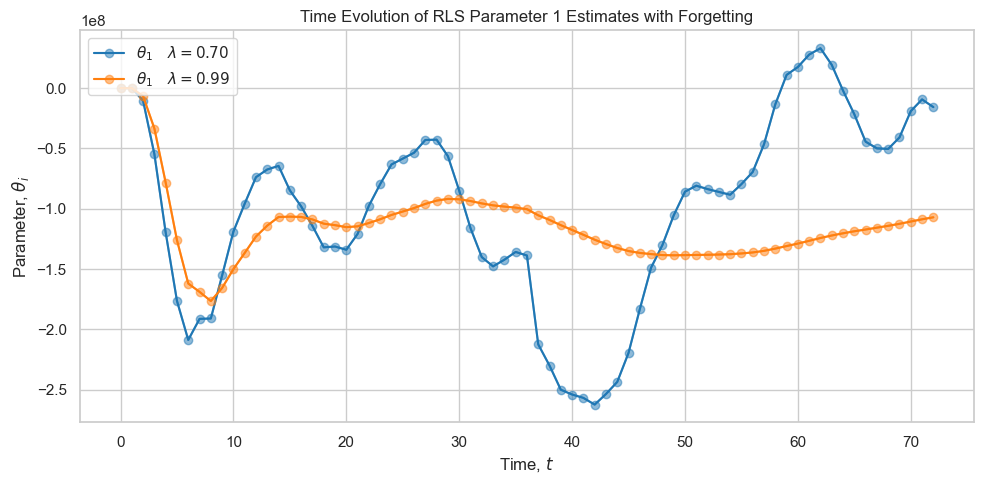

In [99]:
fig, ax1 = plt.subplots()
t = np.arange(thetas_rlsf_1.shape[0])
# df_thetas_rls = pd.DataFrame(thetas_rls_1, columns=["$θ_1$", "$θ_2$"])
thetas_1_l, = plt.plot(t, thetas_rlsf_1[:, 0], c="tab:blue")
thetas_1_s, = plt.plot(t, thetas_rlsf_1[:, 0], c="tab:blue", alpha=0.5, marker="o")
plt.xlabel("Time, $t$")
plt.ylabel("Parameter, $θ_i$")
# thetas_2 = sns.lineplot(thetas_rls_1[:, 1], label="$θ_2$", c="tab:orange")
thetas_2_l, = plt.plot(t, thetas_rlsf_2[:, 0], c="tab:orange")
thetas_2_s, = plt.plot(t, thetas_rlsf_2[:, 0], c="tab:orange", alpha=0.5, marker="o")

# plt.plot(t, thetas_OLS[0] * np.ones_like(t), c="tab:blue", linestyle="--")
plt.legend([(thetas_1_l, thetas_1_s), (thetas_2_l, thetas_2_s)], ["$θ_1 \\quad λ=0.70$", "$θ_1 \\quad λ=0.99$"], loc="upper left")
plt.title("Time Evolution of RLS Parameter 1 Estimates with Forgetting")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_4_rlsf_2_params_1.png", dpi=DPI_EXPORT)

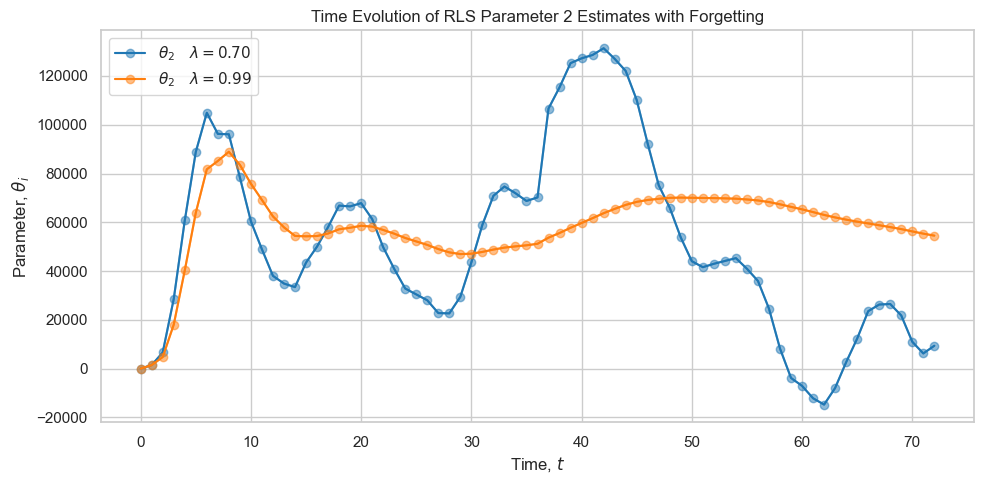

In [100]:
fig, ax1 = plt.subplots()
t = np.arange(thetas_rlsf_1.shape[0])
thetas_1_l, = plt.plot(t, thetas_rlsf_1[:, 1], c="tab:blue")
thetas_1_s, = plt.plot(t, thetas_rlsf_1[:, 1], c="tab:blue", alpha=0.5, marker="o")
plt.xlabel("Time, $t$")
plt.ylabel("Parameter, $θ_i$")
thetas_2_l, = plt.plot(t, thetas_rlsf_2[:, 1], c="tab:orange")
thetas_2_s, = plt.plot(t, thetas_rlsf_2[:, 1], c="tab:orange", alpha=0.5, marker="o")

plt.legend([(thetas_1_l, thetas_1_s), (thetas_2_l, thetas_2_s)], ["$θ_2 \\quad λ=0.70$", "$θ_2 \\quad λ=0.99$"], loc="upper left")
plt.title("Time Evolution of RLS Parameter 2 Estimates with Forgetting")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_4_rlsf_2_params_2.png", dpi=DPI_EXPORT)

In [101]:
wls_1 = wls(ds_train, lambda_=0.7)
df_wls_1 = pd.DataFrame()
df_wls_1["x"] = ds_train.x
df_wls_1["y"] = ds_train.y
df_wls_1["y_pred"] = wls_1.response_prediction
(df_wls_1["y_pred_high"], df_wls_1["y_pred_low"], ) = wls_1.get_prediction_intervals(alpha=0.05)
df_wls_1["Model"] = "WLS"
df_wls_1["Type"] = "Prediction"

wls_2 = wls(ds_train, lambda_=0.99)
df_wls_2 = pd.DataFrame()
df_wls_2["x"] = ds_train.x
df_wls_2["y"] = ds_train.y
df_wls_2["y_pred"] = wls_2.response_prediction
(df_wls_2["y_pred_high"], df_wls_2["y_pred_low"], ) = wls_2.get_prediction_intervals(alpha=0.05)
df_wls_2["Model"] = "WLS"
df_wls_2["Type"] = "Prediction"

print(wls_1.parameters_prediction)
print(wls_2.parameters_prediction)
print(col(thetas_rlsf_1[-1, :]))
print(col(thetas_rlsf_2[-1, :]))

data = []
for x, model, lambda_ in zip([
    wls_1.parameters_prediction,
    wls_2.parameters_prediction,
    col(thetas_rlsf_1[-1, :]),
    col(thetas_rlsf_2[-1, :]),
], ["WLS", "WLS", "RLS", "RLS"], [0.7, 0.99, 0.7, 0.99]):
    data.append({
        "Model": model,
        "$λ$": lambda_,
        "$θ_1$": x[0, 0],
        "$θ_2$": x[1, 0],
    })

df_wls_rls_params = pd.DataFrame(data).set_index("Model").round(2)
df_wls_rls_params.to_csv(OUTPUT_DIR / "wls_rls_params.csv")
df_wls_rls_params

[[-1.57399787e+07]
 [ 9.37098201e+03]]
[[-1.07098187e+08]
 [ 5.45329737e+04]]
[[-1.57399779e+07]
 [ 9.37098161e+03]]
[[-1.07084089e+08]
 [ 5.45259989e+04]]


,$λ$,$θ_1$,$θ_2$
Model,,,
WLS,0.70,-1.573998e+07,9370.98
WLS,0.99,-1.070982e+08,54532.97
RLS,0.70,-1.573998e+07,9370.98
RLS,0.99,-1.070841e+08,54526.00


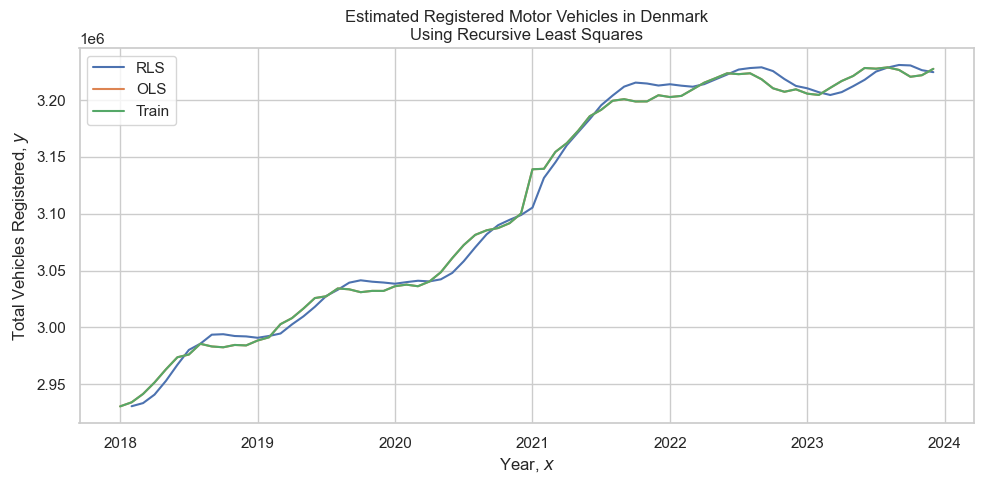

In [102]:
y = []
x = []
for i in range(thetas_rlsf_1.shape[0] - 1):
    y_pred = X @ thetas_rlsf_1[i, :].T
    y.append(y_pred[i])
    x.append(X[i, 1])
K = 1

plt.figure()
plt.plot(x[K:], y[K:], label="RLS")
sns.lineplot(df_ols, x="x", y="y", label="OLS")
sns.lineplot(df_train, x="x", y="y", label="Train")
plt.title("Estimated Registered Motor Vehicles in Denmark\nUsing Recursive Least Squares")
plt.xlabel("Year, $x$")
plt.ylabel("Total Vehicles Registered, $y$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_4_rlsf_1_pred.png", dpi=DPI_EXPORT)

## 4.5

In [103]:

R = R_0.copy()
theta = theta_0.copy()
residuals1 = np.empty((X.shape[0], 1))
k = 1
for i in range(0, X.shape[0] - k):
    x_t = X[i, :][:, None]
    x_k = X[i+k, :][:, None]
    y_t = Y[i]
    y_k = Y[i+k]

    R, theta = rls_step_forgetting(R, theta, forgetting_factor=0.7, x_t=x_t, y_t=y_t)
    y_k_pred = x_k.T @ theta
    residuals1[i] = y_k - y_k_pred


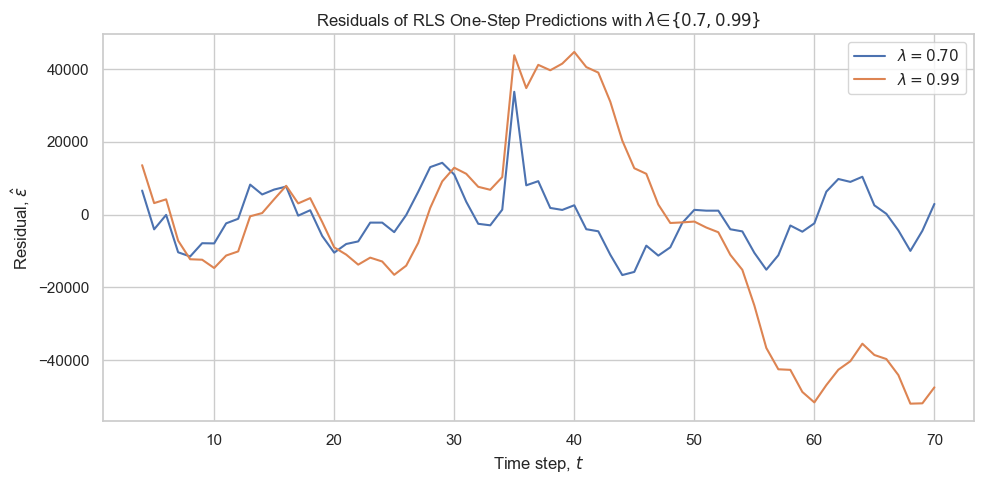

In [104]:

R = R_0.copy()
theta = theta_0.copy()
residuals2 = np.empty((X.shape[0], 1))
k = 1
for i in range(0, X.shape[0] - k):
    x_t = X[i, :][:, None]
    x_k = X[i+k, :][:, None]
    y_t = Y[i]
    y_k = Y[i+k]

    R, theta = rls_step_forgetting(R, theta, forgetting_factor=0.99, x_t=x_t, y_t=y_t)
    y_k_pred = x_k.T @ theta
    residuals2[i] = y_k - y_k_pred

plt.figure()
t = np.arange(residuals1.shape[0])
K = 4
plt.title("Residuals of RLS One-Step Predictions with $λ ∈ \\{0.7, 0.99\\}$")
plt.plot(t[K:], residuals1[K:], label="$λ=0.70$")
plt.plot(t[K:], residuals2[K:], label="$λ=0.99$")
plt.legend()
plt.xlabel("Time step, $t$")
plt.ylabel("Residual, $\\hat{ε}$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_5_rls_residuals.png", dpi=DPI_EXPORT)

## 4.6

In [105]:
pd.DataFrame([{1: 2, 2:3}, {1: 4, 2: 5}])

,1,2
0,2,3
1,4,5


In [106]:
R = R_0.copy()
theta = theta_0.copy()
residuals1 = np.empty((X.shape[0], 1))

residual_cols = {}
K_MAX = 12
ks = np.arange(1, K_MAX + 1)
residual_data = []
for k in ks:
    for lambda_ in np.arange(0.50, 1.0, 0.01):
        R = R_0.copy()
        theta = theta_0.copy()
        residuals = []
        for i in range(0, X.shape[0] - k):
            x_t = X[i, :][:, None]
            x_k = X[i + k, :][:, None]
            y_t = Y[i]
            y_k = Y[i + k]

            R, theta = rls_step_forgetting(
                R, theta, forgetting_factor=lambda_, x_t=x_t, y_t=y_t
            )
            y_k_pred = x_k.T @ theta
            residual = y_k - y_k_pred
            residuals.append(residual[0, 0])

        rmsek = np.sqrt(np.sum(np.square(residuals[4:])) / (len(residuals) - k))

        residual_data.append(
            {
                "k": k,
                "lambda": lambda_,
                "rmsek": rmsek,
            }
        )


In [107]:
df_resids = pd.DataFrame(residual_data)
df_resids

,k,lambda,rmsek
0,1,0.50,6584.742758
1,1,0.51,6626.514828
2,1,0.52,6671.517001
3,1,0.53,6719.870380
4,1,0.54,6771.708064
...,...,...,...
595,12,0.95,59325.732631
596,12,0.96,58555.383907
597,12,0.97,57657.522577
598,12,0.98,56637.341725


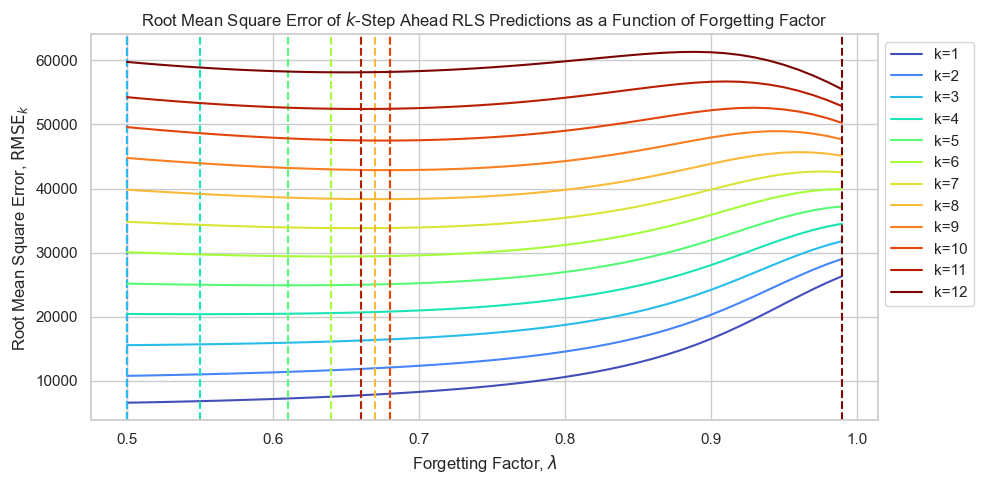

In [108]:
# sns.lineplot(data=df_resids, x="lambda", y="rmsek", hue="k")
cmap = plt.get_cmap("turbo")

optimal_lambdas = {}
plt.figure()
for k, group in df_resids.groupby("k"):
    color = cmap(k / df_resids["k"].max())  # Normalize k to [0, 1] range for colormap
    p = plt.plot(group["lambda"], group["rmsek"], label=f"k={k}", color=color)
    idx_min = group["rmsek"].argmin()
    lambda_min = group["lambda"].iloc[idx_min]
    plt.axvline(lambda_min, color=p[0].get_color(), linestyle="--")
    optimal_lambdas[k] = lambda_min

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.title("Root Mean Square Error of $k$-Step Ahead RLS Predictions as a Function of Forgetting Factor")
plt.xlabel("Forgetting Factor, $λ$")
plt.ylabel("Root Mean Square Error, $\\text{RMSE}_k$")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "plot_4_6_rmsek.png", dpi=DPI_EXPORT)

## 4.7

In [109]:
R = R_0.copy()
theta = theta_0.copy()
residuals1 = np.empty((X.shape[0], 1))

residual_cols = {}
K_MAX = 12
ks = np.arange(1, K_MAX + 1)
residual_data = []

rls_pred = []
lambda_ = 0.65
for i in range(0, X.shape[0]):
    x_t = X[i, :][:, None]
    y_t = Y[i]

    R, theta = rls_step_forgetting(
        R, theta, forgetting_factor=lambda_, x_t=x_t, y_t=y_t
    )

    y_pred = x_t.T @ theta

    rls_pred.append({
        "x": x_t[1, 0],
        "y": y_t,
        "y_pred": y_pred[0, 0],
    })

rls_forecast = []
for k in ks:
    x_k = col(np.asarray([1, df_test["x"].iloc[k-1]]))
    y_k = df_test["y"].iloc[k-1]
    y_k_pred = x_k.T @ theta
    rls_pred.append({
        "x": x_k[1, 0],
        "y": y_k,
        "y_pred": y_k_pred[0, 0],
    })

df_rls_4_7 = pd.DataFrame(rls_pred)
df_rls_4_7["Model"] = "RLS\n$λ=0.65$"
df_rls_4_7["Type"] = "Prediction"

df_rls_4_7_forecast = pd.DataFrame(rls_forecast)
df_rls_4_7_forecast["Model"] = "RLS\n$λ=0.65$"
df_rls_4_7_forecast["Type"] = "Forecast"

In [110]:
ols_4_7 = ols(ds_train)

# Prediction
df_ols_4_7 = pd.DataFrame()
df_ols_4_7["x"] = ds_train.x
df_ols_4_7["y"] = ds_train.y
df_ols_4_7["y_pred"] = ols_4_7.response_prediction
(df_ols_4_7["y_pred_high"], df_ols_4_7["y_pred_low"], ) = ols_4_7.get_prediction_intervals(alpha=0.05)
df_ols_4_7["Model"] = "OLS"
df_ols_4_7["Type"] = "Prediction"

# Forecast
ols_4_7_forecast = ols_4_7.forecast(ds_test)
df_ols_4_7_forecast = pd.DataFrame()
df_ols_4_7_forecast["x"] = ds_test.x
df_ols_4_7_forecast["y"] = ds_test.y
df_ols_4_7_forecast["y_pred"] = ols_4_7_forecast.response_prediction
(df_ols_4_7_forecast["y_pred_high"], df_ols_4_7_forecast["y_pred_low"], ) = ols_4_7_forecast.get_prediction_intervals(alpha=0.05)
df_ols_4_7_forecast["Model"] = "OLS"
df_ols_4_7_forecast["Type"] = "Forecast"


In [111]:
wls_4_7 = wls(ds_train, lambda_=lambda_)

# Prediction
df_wls_4_7 = pd.DataFrame()
df_wls_4_7["x"] = ds_train.x
df_wls_4_7["y"] = ds_train.y
df_wls_4_7["y_pred"] = wls_4_7.response_prediction
(df_wls_4_7["y_pred_high"], df_wls_4_7["y_pred_low"], ) = wls_4_7.get_prediction_intervals(alpha=0.05)
df_wls_4_7["Model"] = "WLS\n$λ=0.65$"
df_wls_4_7["Type"] = "Prediction"

# Forecast
wls_forecast = wls_4_7.forecast(ds_test)
df_wls_4_7_forecast = pd.DataFrame()
df_wls_4_7_forecast["x"] = ds_test.x
df_wls_4_7_forecast["y"] = ds_test.y
df_wls_4_7_forecast["y_pred"] = wls_forecast.response_prediction
(df_wls_4_7_forecast["y_pred_high"], df_wls_4_7_forecast["y_pred_low"], ) = wls_forecast.get_prediction_intervals(alpha=0.05)
df_wls_4_7_forecast["Model"] = "WLS\n$λ=0.65$"
df_wls_4_7_forecast["Type"] = "Forecast"

In [112]:
df_train_4_7 = df_train.copy()
df_train_4_7["Model"] = "Train"
df_train_4_7["Type"] = "Observed"

df_test_4_7 = df_test.copy()
df_test_4_7["Model"] = "Test"
df_test_4_7["Type"] = "Observed"

In [113]:
df_total_4_7 = pd.concat(
    [
        df_train_4_7,
        df_test_4_7,
        df_ols_4_7,
        df_ols_4_7_forecast,
        df_wls_4_7,
        df_wls_4_7_forecast,
        df_rls_4_7,
        df_rls_4_7_forecast,
    ],
    ignore_index=True,
)

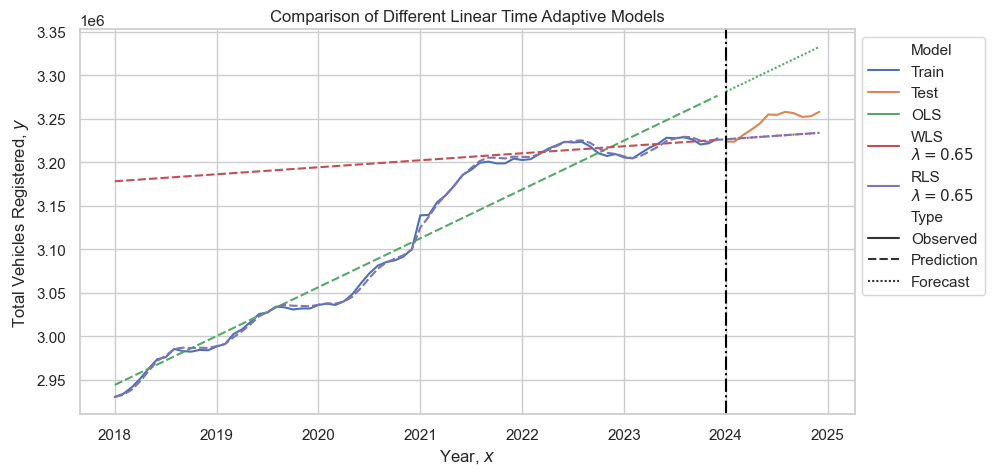

In [114]:
plt.figure()
sns.lineplot(data=df_total_4_7, x="x", y="y_pred", hue="Model", style="Type")
plt.axvline(TRAINING_CUTOFF_X, color="black", linestyle="-.")
plt.title("Comparison of Different Linear Time Adaptive Models")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel("Year, $x$")
plt.ylabel("Total Vehicles Registered, $y$")
plt.savefig(OUTPUT_DIR / "plot_4_7_comparison.png", dpi=DPI_EXPORT)